In [1]:
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

import optuna

from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from gensim.models import FastText

from collections import Counter

import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikitabaramiya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
Xy_train_val = pd.read_csv('data/train.csv', index_col='review_id').fillna('Unknown')
X_train_val, y_train_val = Xy_train_val.iloc[:, :-1], Xy_train_val.iloc[:, -1]

mb = MultiLabelBinarizer(classes=[str(i) for i in range(9)])
y_train_val = mb.fit_transform(y_train_val)

X_test = pd.read_csv('data/test.csv', index_col='review_id').fillna('Unknown')

for data in [X_train_val, X_test]:
    
    # class 0: special symbol
    data['xa_symbol_pos'] = (data['positive'].str.find('\xa0') != -1).astype(int)
    data['xa_symbol_neg'] = (data['negative'].str.find('\xa0') != -1).astype(int)
    
    # small preprocessing
    data['positive'] = data['positive'].str.replace(',', ', ').str.replace('.', '. ').apply(lambda x: re.sub(' +', ' ', x))
    data['negative'] = data['negative'].str.replace(',', ', ').str.replace('.', '. ').apply(lambda x: re.sub(' +', ' ', x))
    
    # class 8: length (woith round -1)
    data['length_pos'] = data['positive'].apply(lambda x: round(len(x), -1)) # .str.len() also works
    data.loc[data['length_pos'] > 1000, 'length_pos'] = 1000
    data['length_neg'] = data['negative'].apply(lambda x: round(len(x), -1))
    data.loc[data['length_neg'] > 1000, 'length_neg'] = 1000
    
    # class 
    data['max_pos'] = data['positive'].apply(lambda x: np.max([len(w) for w in x.split(' ')]))
    data.loc[data['max_pos'] > 25, 'max_pos'] = 25
    data['max_neg'] = data['negative'].apply(lambda x: np.max([len(w) for w in x.split(' ')]))
    data.loc[data['max_neg'] > 25, 'max_neg'] = 25
    
    data['most_common_pos'] = data['positive'].apply(
        lambda x: Counter([w for w in x.split(' ')]).most_common(1)[0][1]
    )
    data.loc[data['most_common_pos'] > 25, 'most_common_pos'] = 25
    data['most_common_neg'] = data['negative'].apply(
        lambda x: Counter([w for w in x.split(' ')]).most_common(1)[0][1]
    )
    data.loc[data['most_common_neg'] > 25, 'most_common_neg'] = 25

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train_val.shape, y_train_val.shape, X_test.shape

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:870: UserWarning: unknown class(es) [','] will be ignored
  warnings.warn(
/var/folders/qr/s242yg692gj9d2qnn_jnhs900000gn/T/ipykernel_27189/1055874452.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['positive'] = data['positive'].str.replace(',', ', ').str.replace('.', '. ').apply(lambda x: re.sub(' +', ' ', x))
/var/folders/qr/s242yg692gj9d2qnn_jnhs900000gn/T/ipykernel_27189/1055874452.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['negative'] = data['negative'].str.replace(',', ', ').str.replace('.', '. ').apply(lambda x: re.sub(' +', ' ', x))


((50876, 18), (50876, 9), (50651, 18))

In [3]:
class SentenceEmbeddingsWithFastText(TransformerMixin):
    """
    FastText model for sentences embeddings
    
    """
    def __init__(self, model=None, 
                 vector_size=25, sg=0, window=3, min_count=10, epochs=10, 
                 low=True, punct=True):
        TransformerMixin.__init__(self)
        
        self.vector_size = vector_size
        self.sg = sg
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        
        self.low = low
        self.punct = punct
        
        if model is None:
            self.model = FastText(vector_size=self.vector_size, sg=self.sg, window=self.window,
                                  min_count=self.min_count, epochs=self.epochs, seed=42, bucket=400_000)
        else:
            self.model = model
        
    @staticmethod
    def tokenize_for_me(sentence, low=True, punct=True):
        
        if low:
            sentence = sentence.lower()
        
        if punct:
            sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        
        return word_tokenize(sentence, language='russian')
    
    def fit(self, X, y=None):
        sentences = list(map(SentenceEmbeddingsWithFastText.tokenize_for_me, list(X)))
        
        self.model.build_vocab(sentences)
        self.model.train(sentences, total_examples=len(sentences), epochs=5)
        
        return self
    
    def transform(self, X, y=None):
        
        sentences = list(map(lambda x: SentenceEmbeddingsWithFastText.tokenize_for_me(x, 
                                                                                      low=self.low, 
                                                                                      punct=self.punct),
                             list(X)))
        
        return np.stack(list(map(
            lambda x: self.model.wv[x].mean(axis=0) if len(x) > 0 else np.zeros(self.vector_size), sentences
        )))
    
    def fit_transform(self, X, y=None):
        sentences = list(map(lambda x: SentenceEmbeddingsWithFastText.tokenize_for_me(x, 
                                                                                      low=self.low, 
                                                                                      punct=self.punct),
                             list(X)))
                
        self.model.build_vocab(sentences)
        self.model.train(sentences, total_examples=len(sentences), epochs=5)
        
        return np.stack(list(map(
            lambda x: self.model.wv[x].mean(axis=0) if len(x) > 0 else np.zeros(self.vector_size), sentences
        )))
    
    def get_params(self, deep=True):
        return {
            'model': self.model,
            'vector_size': self.vector_size,
            'sg': self.sg,
            'window': self.window,
            'min_count': self.min_count,
            'epochs': self.epochs,
            'low': self.low,
            'punct': self.punct,
        }

In [4]:
class RatingStatistics(TransformerMixin):
    """
    Rating Statistics
    
    """
    def __init__(self, value=None):
        TransformerMixin.__init__(self)
        
        self.value = value
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        
        features = [np.mean(X, axis=1).reshape(-1, 1), np.std(X, axis=1).reshape(-1, 1)]
        
        for i in range(5+1):
            features.append((X == i).sum(axis=1).reshape(-1, 1))
        
        return np.concatenate(features, axis=1)
    
    def fit_transform(self, X, y=None):
        X = np.array(X)
        
        features = [np.mean(X, axis=1).reshape(-1, 1), np.std(X, axis=1).reshape(-1, 1)]
        
        for i in range(5+1):
            features.append((X == i).sum(axis=1).reshape(-1, 1))
        
        return np.concatenate(features, axis=1)
    
    def get_params(self, deep=True):
        return {
            'value': self.value,
        }

In [6]:
def objective(trial):
    
    param_lr = {
        "C": trial.suggest_float("C", 1e-3, 1.0, log=True),
    }
    
    param_embed = {
        "vector_size": trial.suggest_int("vector_size", 50, 300, step=50),
        "sg": trial.suggest_categorical("sg", [0, 1]),
        "window": trial.suggest_int("window", 2, 25, step=1),
        "min_count": trial.suggest_int("min_count", 5, 50, step=5),
        "epochs": trial.suggest_int("epochs", 5, 15, step=2),
        "low": trial.suggest_categorical("low", [True, False]),
        "punct": trial.suggest_categorical("punct", [True, False]),
    }
    
    score = 0
    for seed in [0, 42, 100]:
        train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)
        
        pipeline = Pipeline([
            ('transforms', ColumnTransformer([
                ('ohe', OneHotEncoder(handle_unknown='ignore'), [0, 1] + [*range(4, X_val.shape[1])]),
                ('embed1', SentenceEmbeddingsWithFastText(**param_embed), 2),
                ('embed2', SentenceEmbeddingsWithFastText(**param_embed), 3),
                ('edatricks', RatingStatistics(), [4, 5, 6, 7, 8, 9]),
            ])),
            ('sc', StandardScaler()),
            ('lr', OneVsRestClassifier(LogisticRegression(**param_lr, n_jobs=-1, random_state=42), n_jobs=1))
        ])

        pipeline.fit(train_x, train_y)
        
        score += f1_score(valid_y, pipeline.predict(valid_x), average='samples')
    
    return score / 3

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-02-18 19:35:14,809] A new study created in memory with name: no-name-399e4ec8-2219-4120-9a14-ab5e36eab49b


KeyboardInterrupt: 

In [ ]:
trial = study.best_trial

print(f"Number of finished trials: {len(study.trials)}")

print(f"Best trial value: {trial.value:.2f}")

print("Params: ")
for key, value in trial.params.items():
    print(f"\t {key}: {value:.2f}")

In [9]:
param = list(trial.params.items())

param_embed = dict(param[-5:])
param_lgbm = dict(param[:-5])

In [10]:
pipeline = Pipeline([
    ('transforms', ColumnTransformer([
        ('te', TargetEncoderForMultilabel(), [0, 1, 4, 5, 6, 7, 8, 9]),
        ('embed1', SentenceEmbeddingsWithFastText(**param_embed), 2),
        ('embed2', SentenceEmbeddingsWithFastText(**param_embed), 3),
        ('edatricks1', EDATricks(), 2),
        ('edatricks2', EDATricks(), 3),
        ('edatricks3', RatingStatistics(), [4, 5, 6, 7, 8, 9]),
    ])),
    ('lgbm', OneVsRestClassifier(LGBMClassifier(**param_lgbm, n_jobs=1, random_state=42), n_jobs=1))
])
pipeline.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6928078295805302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6928078295805302
[LightGBM] [Warning] bagging_fraction is set=0.9540949735246711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9540949735246711
[LightGBM] [Warning] lambda_l2 is set=7.367457040850964e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.367457040850964e-08
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] lambda_l1 is set=0.029790544981579827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029790544981579827


Pipeline(steps=[('transforms',
                 ColumnTransformer(transformers=[('te',
                                                  [0, 1, 4, 5, 6, 7, 8, 9]),
                                                 ('embed1',
                                                  2),
                                                 ('embed2',
                                                  3),
                                                 ('edatricks1',
                                                  <__main__.EDATricks object at 0x7ff3f6...
                                                 ('edatricks3',
                                                  [4, 5, 6, 7, 8, 9])])),
                ('lgbm',
                 OneVsRestClassifier(estimator=LGBMClassifier(bagging_fraction=0.9540949735246711,
                                                              bagging_freq=4,
                                                              feature_fraction=0.6928078295805302,
             

In [16]:
# f1_score(y_val, pipeline.predict(X_val), average='samples')

In [12]:
pipeline = Pipeline([
    ('transforms', ColumnTransformer([
        ('te', TargetEncoderForMultilabel(), [0, 1, 4, 5, 6, 7, 8, 9]),
        ('embed1', SentenceEmbeddingsWithFastText(**param_embed), 2),
        ('embed2', SentenceEmbeddingsWithFastText(**param_embed), 3),
        ('edatricks1', EDATricks(), 2),
        ('edatricks2', EDATricks(), 3),
        ('edatricks3', RatingStatistics(), [4, 5, 6, 7, 8, 9]),
    ])),
    ('lgbm', OneVsRestClassifier(LGBMClassifier(**param_lgbm, n_jobs=1, random_state=42), n_jobs=1))
])
pipeline.fit(X_train_val, y_train_val)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6928078295805302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6928078295805302
[LightGBM] [Warning] bagging_fraction is set=0.9540949735246711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9540949735246711
[LightGBM] [Warning] lambda_l2 is set=7.367457040850964e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.367457040850964e-08
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] lambda_l1 is set=0.029790544981579827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029790544981579827


Pipeline(steps=[('transforms',
                 ColumnTransformer(transformers=[('te',
                                                  [0, 1, 4, 5, 6, 7, 8, 9]),
                                                 ('embed1',
                                                  2),
                                                 ('embed2',
                                                  3),
                                                 ('edatricks1',
                                                  <__main__.EDATricks object at 0x7ff405...
                                                 ('edatricks3',
                                                  [4, 5, 6, 7, 8, 9])])),
                ('lgbm',
                 OneVsRestClassifier(estimator=LGBMClassifier(bagging_fraction=0.9540949735246711,
                                                              bagging_freq=4,
                                                              feature_fraction=0.6928078295805302,
             

In [13]:
joblib.dump(pipeline, 'model_16022022')

['model_16022022']

In [14]:
def predict_multilabel(model, X):
    y_pred = list(map(lambda x: ','.join(x), mb.inverse_transform(model.predict(X))))
    y_pred_top1 = model.predict_proba(X).argmax(axis=1)
    
    return np.where([len(x) > 0 for x in y_pred], y_pred, y_pred_top1)

In [15]:
model = joblib.load('model_16022022')

pd.DataFrame({
    'review_id': X_test.index, 
    'target': predict_multilabel(model, X_test) # model.predict(X_test).flatten()
}).to_csv('answers.csv', index=False)

In [19]:
# Number of finished trials: 25
# Best trial value: 0.81
# Params: 
# 	 lambda_l1: 0.03
# 	 lambda_l2: 0.00
# 	 num_leaves: 56.00
# 	 feature_fraction: 0.69
# 	 bagging_fraction: 0.95
# 	 bagging_freq: 4.00
# 	 min_data_in_leaf: 149.00
# 	 vector_size: 20.00
# 	 sg: 1.00
# 	 window: 5.00
# 	 min_count: 15.00
# 	 epochs: 5.00
# 0.759871111988

In [38]:
cols = X_train.iloc[:, [0, 1, 4, 5, 6, 7, 8, 9]].columns.tolist() + \
[f'pos_{i}' for i in range(0, 25)] + [f'neg_{i}' for i in range(0, 25)] + \
['X_pos_0', 'X_pos_2', 'X_pos_3', 'X_pos_5', 'X_pos_8'] + ['X_neg_0', 'X_neg_2', 'X_neg_3', 'X_neg_5', 'X_neg_8']

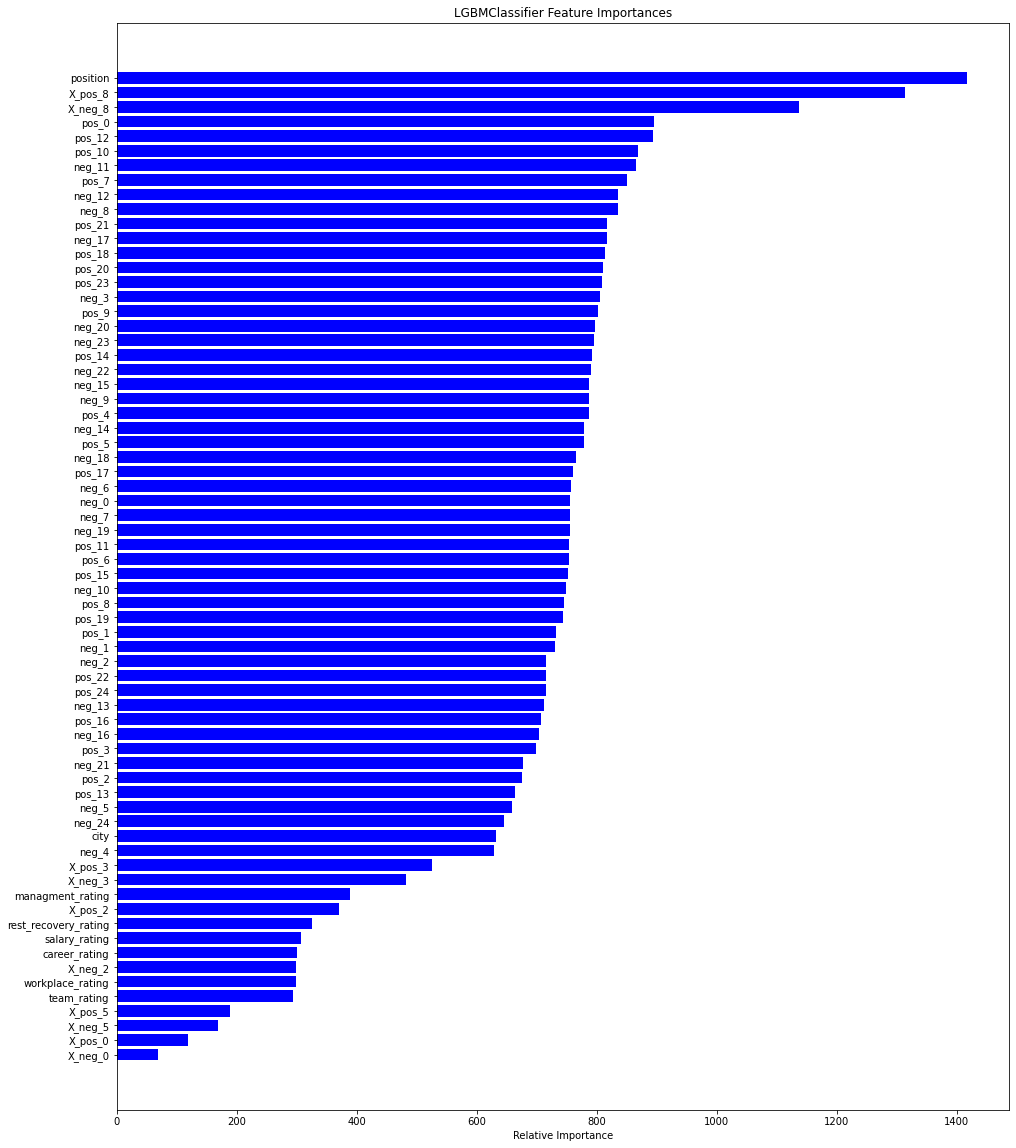

In [39]:
def plot_feature_importance(model, model_name, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(16, 20))
    plt.title(f'{model_name} Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_feature_importance(pipeline['lr'], 'LGBMClassifier', cols)

In [47]:
cols = X_train.iloc[:, [0, 1, 4, 5, 6, 7, 8, 9]].columns.tolist() + \
[f'text_{i}' for i in range(0, 25)] + [f'text_{i}' for i in range(0, 25)] + \
['X_0', 'X_2', 'X_3', 'X_5', 'X_8'] + ['X_0', 'X_2', 'X_3', 'X_5', 'X_8']

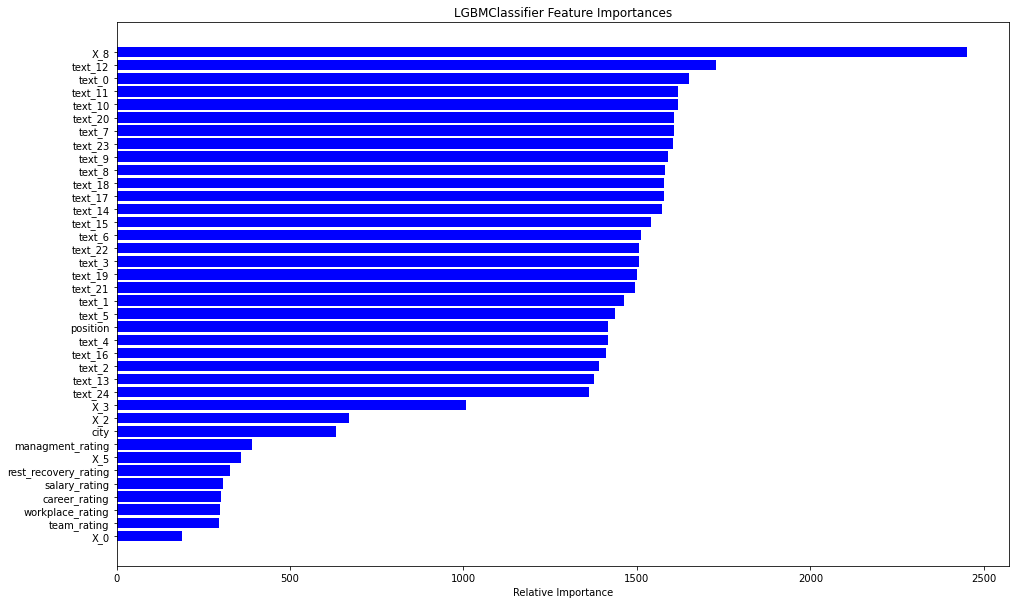

In [48]:
def plot_feature_importance(model, model_name, features):
    
    data = pd.DataFrame({
        'cols': features, 'importances': pipeline['lr'].feature_importances_
    }).groupby('cols').sum().reset_index()
    
    importances = data.importances.values
    indices = np.argsort(importances)
    
    features = data.cols.values
    
    plt.figure(figsize=(16, 10))
    plt.title(f'{model_name} Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_feature_importance(pipeline['lr'], 'LGBMClassifier', cols)

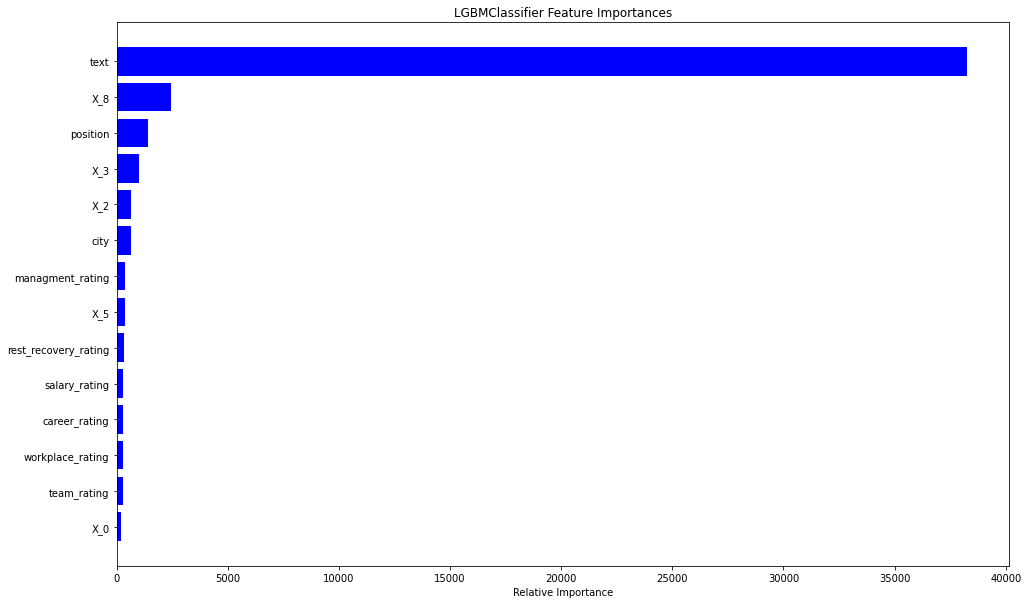

In [51]:
cols = X_train.iloc[:, [0, 1, 4, 5, 6, 7, 8, 9]].columns.tolist() + \
[f'text' for i in range(0, 25)] + [f'text' for i in range(0, 25)] + \
['X_0', 'X_2', 'X_3', 'X_5', 'X_8'] + ['X_0', 'X_2', 'X_3', 'X_5', 'X_8']

def plot_feature_importance(model, model_name, features):
    
    data = pd.DataFrame({
        'cols': features, 'importances': pipeline['lr'].feature_importances_
    }).groupby('cols').sum().reset_index()
    
    importances = data.importances.values
    indices = np.argsort(importances)
    
    features = data.cols.values
    
    plt.figure(figsize=(16, 10))
    plt.title(f'{model_name} Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_feature_importance(pipeline['lr'], 'LGBMClassifier', cols)